# 首先，我们从递进编码之后的数据开始

In [80]:
import sys 
sys.path.append('./xgboost/python-package/')
sys.path.append('./fancyimpute/fancyimpute/')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline, make_pipeline
from scipy.stats import skew
from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.linear_model import ElasticNet, SGDRegressor, BayesianRidge
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

pd.set_option("display.max_columns",1000000)
pd.set_option('display.max_rows', 1000000)

In [81]:
from fancyimpute import KNN 

In [82]:
train = pd.read_csv('./remastered.csv')
test = pd.read_csv('./test_prepro.csv')

In [83]:
train_target = train['SalePrice']

In [84]:
train = train.drop(['index','Id'],axis = 1)
test = test.drop(['index','Id'],axis = 1)

# 把year labelencoder

In [85]:
train['MSSubClass'] = train['MSSubClass'].astype(object)
test['MSSubClass'] = test['MSSubClass'].astype(object)

In [86]:
lis = ['YrSold','YearBuilt','YearRemodAdd','GarageYrBlt']
train[lis] = train[lis].astype(object)
test[lis] = test[lis].astype(object)

In [87]:
label = LabelEncoder()

In [88]:
train["YearBuilt"] = label.fit_transform(train["YearBuilt"])
train["YearRemodAdd"] = label.fit_transform(train["YearRemodAdd"])
train["GarageYrBlt"] = label.fit_transform(train["GarageYrBlt"])
train["YrSold"] = label.fit_transform(train["YrSold"])

test["YearBuilt"] = label.fit_transform(test["YearBuilt"])
test["YearRemodAdd"] = label.fit_transform(test["YearRemodAdd"])
test["GarageYrBlt"] = label.fit_transform(test["GarageYrBlt"])
test["YrSold"] = label.fit_transform(test["YrSold"])

In [89]:
train_without4_without_price = train.drop(['LotFrontage','MasVnrArea','MasVnrType','Electrical','SalePrice'],axis=1)
test_without4 = test.drop(['LotFrontage','MasVnrArea','MasVnrType','Electrical'],axis=1)

In [90]:
train_without4_without_price.shape

(1460, 75)

In [91]:
test_without4.shape

(1459, 75)

# 特征工程

In [92]:
def transform(X):
    X["TotalHouse"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"]   
    X["TotalArea"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"]

    X["+_TotalHouse_OverallQual"] = X["TotalHouse"] * X["OverallQual"]
    X["+_GrLivArea_OverallQual"] = X["GrLivArea"] * X["OverallQual"]

    
    X["+_BsmtFinSF1_OverallQual"] = X["BsmtFinSF1"] * X["OverallQual"]

    X["-_Functional_TotalHouse"] = X["Functional"] * X["TotalHouse"]
    X["-_Functional_OverallQual"] = X["Functional"] + X["OverallQual"]
    X["-_LotArea_OverallQual"] = X["LotArea"] * X["OverallQual"]
    X["-_TotalHouse_LotArea"] = X["TotalHouse"] + X["LotArea"]



    X["Bsmt"] = X["BsmtFinSF1"] + X["BsmtFinSF2"] + X["BsmtUnfSF"]
    X["Rooms"] = X["FullBath"]+X["TotRmsAbvGrd"]
    X["PorchArea"] = X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]
    X["TotalPlace"] = X["TotalBsmtSF"] + X["1stFlrSF"] + X["2ndFlrSF"] + X["GarageArea"] + X["OpenPorchSF"]+X["EnclosedPorch"]+X["3SsnPorch"]+X["ScreenPorch"]


    return X

In [93]:
train_without4_without_price = transform(train_without4_without_price)
test_without4 = transform(test_without4)

In [94]:
train_without4_without_price.shape

(1460, 88)

In [95]:
test_without4.shape

(1459, 88)

# 删数据

In [96]:
def define_outlier(df, cols):
    outlier_list_col = []
    for feature in cols:
        Q1 = np.percentile(df[feature],25)
        Q3 = np.percentile(df[feature],75)
        IQR = Q3-Q1
        outlier_step = 1.5*IQR
        outlier_list = df[(df[feature]<(Q1-IQR)) | (df[feature]>(Q3+IQR))].index
        if len(outlier_list)>0:
            outlier_list_col.append(feature)
    return outlier_list_col

# 做skew 和 one hot

In [97]:
X_numeric=train_without4_without_price.select_dtypes(exclude=["object"])
skewness = X_numeric.apply(lambda x: skew(x))
skewness_features = skewness[abs(skewness) >= 0.75].index
train_without4_without_price[skewness_features] = np.log1p(train_without4_without_price[skewness_features])
train_without4_without_price = pd.get_dummies(train_without4_without_price)

In [98]:
X_numeric=test_without4.select_dtypes(exclude=["object"])
skewness = X_numeric.apply(lambda x: skew(x))
skewness_features = skewness[abs(skewness) >= 0.75].index
test_without4[skewness_features] = np.log1p(test_without4[skewness_features])
test_without4 = pd.get_dummies(test_without4)

# concat 之后，所有train 和test  feature 自动排序和填补空缺值0，然后再切分

In [99]:
full = pd.concat([train_without4_without_price,test_without4])

/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [100]:
full.head(5)

,+_BsmtFinSF1_OverallQual,+_GrLivArea_OverallQual,+_TotalHouse_OverallQual,-_Functional_OverallQual,-_Functional_TotalHouse,-_LotArea_OverallQual,-_TotalHouse_LotArea,1stFlrSF,2ndFlrSF,3SsnPorch,Alley,BedroomAbvGr,BldgType_1Fam,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,Bsmt,BsmtCond,BsmtExposure,BsmtFinSF1,BsmtFinSF2,BsmtFinType1,BsmtFinType2,BsmtFullBath,BsmtHalfBath,BsmtQual,BsmtUnfSF,CentralAir_N,CentralAir_Y,Condition1_Artery,Condition1_Feedr,Condition1_Norm,Condition1_PosA,Condition1_PosN,Condition1_RRAe,Condition1_RRAn,Condition1_RRNe,Condition1_RRNn,Condition2_Artery,Condition2_Feedr,Condition2_Norm,Condition2_PosA,Condition2_PosN,Condition2_RRAe,Condition2_RRAn,Condition2_RRNn,EnclosedPorch,ExterCond,ExterQual,Exterior1st_0,Exterior1st_AsbShng,Exterior1st_AsphShn,Exterior1st_BrkComm,Exterior1st_BrkFace,Exterior1st_CBlock,Exterior1st_CemntBd,Exterior1st_HdBoard,Exterior1st_ImStucc,Exterior1st_MetalSd,Exterior1st_Plywood,Exterior1st_Stone,Exterior1st_Stucco,Exterior1st_VinylSd,Exterior1st_Wd Sdng,Exterior1st_WdShing,Exterior2nd_0,Exterior2nd_AsbShng,Exterior2nd_AsphShn,Exterior2nd_Brk Cmn,Exterior2nd_BrkFace,Exterior2nd_CBlock,Exterior2nd_CmentBd,Exterior2nd_HdBoard,Exterior2nd_ImStucc,Exterior2nd_MetalSd,Exterior2nd_Other,Exterior2nd_Plywood,Exterior2nd_Stone,Exterior2nd_Stucco,Exterior2nd_VinylSd,Exterior2nd_Wd Sdng,Exterior2nd_Wd Shng,Fence,FireplaceQu,Fireplaces,Foundation,FullBath,Functional,GarageArea,GarageCars,GarageCond,GarageFinish,GarageQual,GarageType,GarageYrBlt,GrLivArea,HalfBath,Heating,HeatingQC,HouseStyle,KitchenAbvGr,KitchenQual,LandContour,LandSlope,LotArea,LotConfig,LotShape,LowQualFinSF,MSSubClass_120,MSSubClass_150,MSSubClass_160,MSSubClass_180,MSSubClass_190,MSSubClass_20,MSSubClass_30,MSSubClass_40,MSSubClass_45,MSSubClass_50,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSZoning_0,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,MiscFeature_Gar2,MiscFeature_Othr,MiscFeature_Shed,MiscFeature_TenC,MiscVal,MoSold,Neighborhood_Blmngtn,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,OpenPorchSF,OverallCond,OverallQual,PavedDrive,PoolArea,PoolQC,PorchArea,RoofMatl,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,Rooms,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial,SaleType_0,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,ScreenPorch,Street,TotRmsAbvGrd,TotalArea,TotalBsmtSF,TotalHouse,TotalPlace,Utilities,WoodDeckSF,YearBuilt,YearRemodAdd,YrSold
0,8.505728,9.390242,9.796069,15.0,9.929594,10.987849,9.307195,6.753438,6.751101,0.0,0.0,3,1,0,0,0,0,6.753438,1.386294,0.693147,6.561031,0.0,6,0.693147,1,0.000000,1.609438,5.017280,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0.0,0.0,0.0,0.000000,1.386294,1.609438,NaN,0,0,0,0,0,0,0,0.0,0,0,0.0,0,1,0,0,NaN,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1,0,0,0.0,0,0.0,4,2,2.197225,548,2,1.386294,2,1.386294,5,90,7.444833,1,1.791759,5,1.609438,0.693147,4,1.609438,1.386294,9.042040,1.791759,1.609438,0.0,0,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0,0,NaN,0,0,0,1,0,0,0,0,0.0,0.0,2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.127134,5,7,1.386294,0.0,0.0,4.127134,1.098612,0,1,0,0,0,0,10,0,0,0,0,1,0,NaN,0,0,0,0,0,0,0,0,1,0.0,1.098612,8.0,8.043984,6.753438,7.850493,8.063378,1.609438,0.000000,104,53,2
1,8.677440,8.932345,9.625426,14.0,9.913091,10.961295,9.403025,7.141245,0.000000,0.0,0.0,3,1,0,0,0,

In [101]:
full = full.fillna(0)

In [102]:
train_without4_without_price_want_to_impute = full.iloc[:1460,:]
test_without4_want_to_impute = full.iloc[1460:,:]

In [103]:
train_without4_without_price_want_to_impute.isnull().sum()

+_BsmtFinSF1_OverallQual    0
+_GrLivArea_OverallQual     0
+_TotalHouse_OverallQual    0
-_Functional_OverallQual    0
-_Functional_TotalHouse     0
-_LotArea_OverallQual       0
-_TotalHouse_LotArea        0
1stFlrSF                    0
2ndFlrSF                    0
3SsnPorch                   0
Alley                       0
BedroomAbvGr                0
BldgType_1Fam               0
BldgType_2fmCon             0
BldgType_Duplex             0
BldgType_Twnhs              0
BldgType_TwnhsE             0
Bsmt                        0
BsmtCond                    0
BsmtExposure                0
BsmtFinSF1                  0
BsmtFinSF2                  0
BsmtFinType1                0
BsmtFinType2                0
BsmtFullBath                0
BsmtHalfBath                0
BsmtQual                    0
BsmtUnfSF                   0
CentralAir_N                0
CentralAir_Y                0
Condition1_Artery           0
Condition1_Feedr            0
Condition1_Norm             0
Condition1

In [104]:
test_without4_want_to_impute.isnull().sum()

+_BsmtFinSF1_OverallQual    0
+_GrLivArea_OverallQual     0
+_TotalHouse_OverallQual    0
-_Functional_OverallQual    0
-_Functional_TotalHouse     0
-_LotArea_OverallQual       0
-_TotalHouse_LotArea        0
1stFlrSF                    0
2ndFlrSF                    0
3SsnPorch                   0
Alley                       0
BedroomAbvGr                0
BldgType_1Fam               0
BldgType_2fmCon             0
BldgType_Duplex             0
BldgType_Twnhs              0
BldgType_TwnhsE             0
Bsmt                        0
BsmtCond                    0
BsmtExposure                0
BsmtFinSF1                  0
BsmtFinSF2                  0
BsmtFinType1                0
BsmtFinType2                0
BsmtFullBath                0
BsmtHalfBath                0
BsmtQual                    0
BsmtUnfSF                   0
CentralAir_N                0
CentralAir_Y                0
Condition1_Artery           0
Condition1_Feedr            0
Condition1_Norm             0
Condition1

In [105]:
train_only4 = train[['LotFrontage','MasVnrArea','MasVnrType','Electrical']]
test_only4 = test[['LotFrontage','MasVnrArea','MasVnrType','Electrical']]

In [106]:
train_only4.head(5)


,LotFrontage,MasVnrArea,MasVnrType,Electrical
0,65.0,196.0,3.0,5.0
1,80.0,0.0,1.0,5.0
2,68.0,162.0,3.0,5.0
3,60.0,0.0,1.0,5.0
4,84.0,350.0,3.0,5.0


In [107]:
test_only4.head(5)

,LotFrontage,MasVnrArea,MasVnrType,Electrical
0,80.0,0.0,1.0,5
1,81.0,108.0,3.0,5
2,74.0,0.0,1.0,5
3,78.0,20.0,3.0,5
4,43.0,0.0,1.0,5


In [108]:
train_with4 = pd.concat([train_without4_without_price_want_to_impute,train_only4],axis=1)
test_with4 = pd.concat([test_without4_want_to_impute,test_only4],axis=1)


In [109]:
all_column_name = list(train_with4.columns)


# 自动补全

In [110]:
X_filled_knn_train = KNN(k=3).fit_transform(train_with4)
X_filled_knn_test = KNN(k=3).fit_transform(test_with4)

Imputing row 1/1460 with 0 missing, elapsed time: 1.962
Imputing row 101/1460 with 1 missing, elapsed time: 1.964
Imputing row 201/1460 with 0 missing, elapsed time: 1.966
Imputing row 301/1460 with 0 missing, elapsed time: 1.967
Imputing row 401/1460 with 0 missing, elapsed time: 1.969
Imputing row 501/1460 with 0 missing, elapsed time: 1.970
Imputing row 601/1460 with 0 missing, elapsed time: 1.971
Imputing row 701/1460 with 0 missing, elapsed time: 1.973
Imputing row 801/1460 with 0 missing, elapsed time: 1.975
Imputing row 901/1460 with 1 missing, elapsed time: 1.977
Imputing row 1001/1460 with 0 missing, elapsed time: 1.979
Imputing row 1101/1460 with 0 missing, elapsed time: 1.982
Imputing row 1201/1460 with 0 missing, elapsed time: 1.984
Imputing row 1301/1460 with 1 missing, elapsed time: 1.986
Imputing row 1401/1460 with 0 missing, elapsed time: 1.988
Imputing row 1/1459 with 0 missing, elapsed time: 1.960
Imputing row 101/1459 with 0 missing, elapsed time: 1.962
Imputing row 

In [111]:
fullfill_train = pd.DataFrame(X_filled_knn_train,columns=all_column_name)
fullfill_test = pd.DataFrame(X_filled_knn_test,columns=all_column_name)

In [112]:
fullfill_train.isnull().sum()

+_BsmtFinSF1_OverallQual    0
+_GrLivArea_OverallQual     0
+_TotalHouse_OverallQual    0
-_Functional_OverallQual    0
-_Functional_TotalHouse     0
-_LotArea_OverallQual       0
-_TotalHouse_LotArea        0
1stFlrSF                    0
2ndFlrSF                    0
3SsnPorch                   0
Alley                       0
BedroomAbvGr                0
BldgType_1Fam               0
BldgType_2fmCon             0
BldgType_Duplex             0
BldgType_Twnhs              0
BldgType_TwnhsE             0
Bsmt                        0
BsmtCond                    0
BsmtExposure                0
BsmtFinSF1                  0
BsmtFinSF2                  0
BsmtFinType1                0
BsmtFinType2                0
BsmtFullBath                0
BsmtHalfBath                0
BsmtQual                    0
BsmtUnfSF                   0
CentralAir_N                0
CentralAir_Y                0
Condition1_Artery           0
Condition1_Feedr            0
Condition1_Norm             0
Condition1

In [113]:
fullfill_test.isnull().sum()

+_BsmtFinSF1_OverallQual    0
+_GrLivArea_OverallQual     0
+_TotalHouse_OverallQual    0
-_Functional_OverallQual    0
-_Functional_TotalHouse     0
-_LotArea_OverallQual       0
-_TotalHouse_LotArea        0
1stFlrSF                    0
2ndFlrSF                    0
3SsnPorch                   0
Alley                       0
BedroomAbvGr                0
BldgType_1Fam               0
BldgType_2fmCon             0
BldgType_Duplex             0
BldgType_Twnhs              0
BldgType_TwnhsE             0
Bsmt                        0
BsmtCond                    0
BsmtExposure                0
BsmtFinSF1                  0
BsmtFinSF2                  0
BsmtFinType1                0
BsmtFinType2                0
BsmtFullBath                0
BsmtHalfBath                0
BsmtQual                    0
BsmtUnfSF                   0
CentralAir_N                0
CentralAir_Y                0
Condition1_Artery           0
Condition1_Feedr            0
Condition1_Norm             0
Condition1

In [114]:
fullfill_train['SalePrice'] = train_target

In [115]:
fullfill_train_X = fullfill_train.drop(['SalePrice'],axis = 1)

In [116]:
fullfill_train_X.shape

(1460, 209)

In [117]:
fullfill_train.shape

(1460, 210)

In [118]:
fullfill_test.shape

(1459, 209)

# scalar

In [119]:
scaler = RobustScaler()
X_scaled_train = scaler.fit(fullfill_train_X).transform(fullfill_train_X)
X_scaled_test = scaler.fit(fullfill_test).transform(fullfill_test)

In [120]:
fullfill_train_X.to_csv('fullfill_train_X.csv',index = False)

## log price

In [121]:
log_train_target = np.log(train_target)

# 现在用feature selection 去验证源数据是否选择差不多,结果是 差不多的！！

In [122]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled_train,log_train_target)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=fullfill_train_X.columns)
FI_lasso.sort_values("Feature Importance",ascending=False)

,Feature Importance
OverallQual,1.067874e-01
Neighborhood_Crawfor,8.593636e-02
Neighborhood_StoneBr,8.424099e-02
GrLivArea,8.121814e-02
Neighborhood_NridgHt,7.761588e-02
YearBuilt,7.508771e-02
-_Functional_TotalHouse,7.110391e-02
Neighborhood_NoRidge,6.390335e-02
Exterior1st_BrkFace,5.330965e-02
Condition1_Norm,5.221640e-02


In [123]:
FI_lasso.sort_values("Feature Importance",ascending=False).index[:100]

Index(['OverallQual', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr',
       'GrLivArea', 'Neighborhood_NridgHt', 'YearBuilt',
       '-_Functional_TotalHouse', 'Neighborhood_NoRidge',
       'Exterior1st_BrkFace', 'Condition1_Norm', 'TotalPlace',
       'Neighborhood_BrkSide', 'BsmtFinSF1', 'GarageCars',
       'Neighborhood_Somerst', 'OverallCond', '-_TotalHouse_LotArea',
       'BldgType_1Fam', 'HeatingQC', 'KitchenQual', 'SaleType_New',
       'BsmtFullBath', 'FireplaceQu', 'YearRemodAdd', 'RoofMatl', 'HalfBath',
       'BsmtExposure', 'BsmtQual', 'FullBath', 'MSSubClass_20', 'Fireplaces',
       'WoodDeckSF', 'Exterior1st_MetalSd', 'BsmtFinType1', '1stFlrSF',
       'ExterQual', 'SaleCondition_Normal', 'ScreenPorch', 'Rooms',
       'GarageFinish', 'RoofStyle_Hip', 'Exterior2nd_VinylSd', 'LowQualFinSF',
       '-_Functional_OverallQual', 'MasVnrArea', 'LotArea', '3SsnPorch',
       'EnclosedPorch', 'CentralAir_Y', 'MiscFeature_Shed',
       'Neighborhood_Blueste', 'Neighborhood_Bl

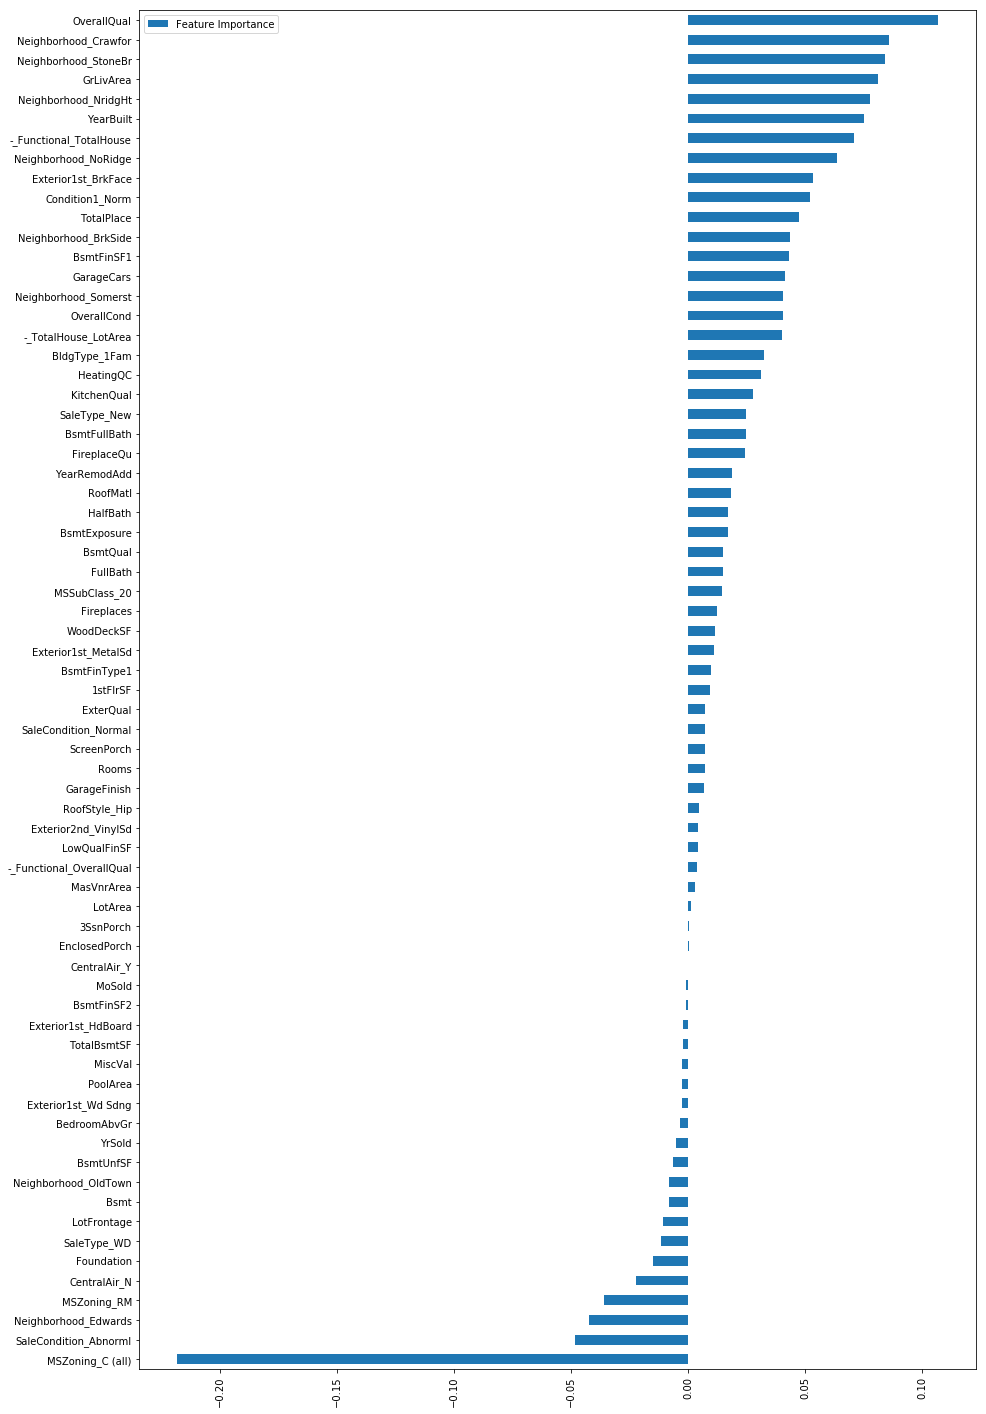

In [124]:
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

In [125]:
fullfill_train_X = fullfill_train_X[['OverallQual', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr',
       'GrLivArea', 'Neighborhood_NridgHt', 'YearBuilt',
       '-_Functional_TotalHouse', 'Neighborhood_NoRidge',
       'Exterior1st_BrkFace', 'Condition1_Norm', 'TotalPlace',
       'Neighborhood_BrkSide', 'BsmtFinSF1', 'GarageCars',
       'Neighborhood_Somerst', 'OverallCond', '-_TotalHouse_LotArea',
       'BldgType_1Fam', 'HeatingQC', 'KitchenQual', 'SaleType_New',
       'BsmtFullBath', 'FireplaceQu', 'YearRemodAdd', 'RoofMatl', 'HalfBath',
       'BsmtExposure', 'BsmtQual', 'FullBath', 'MSSubClass_20', 'Fireplaces',
       'WoodDeckSF', 'Exterior1st_MetalSd', 'BsmtFinType1', '1stFlrSF',
       'ExterQual', 'SaleCondition_Normal', 'ScreenPorch', 'Rooms',
       'GarageFinish', 'RoofStyle_Hip', 'Exterior2nd_VinylSd', 'LowQualFinSF',
       '-_Functional_OverallQual', 'MasVnrArea', 'LotArea', '3SsnPorch',
       'EnclosedPorch', 'CentralAir_Y', 'MiscFeature_Shed',
       'Neighborhood_Blueste', 'Neighborhood_Blmngtn', 'Utilities',
       'MiscFeature_Othr', 'MiscFeature_TenC', 'MiscFeature_Gar2',
       'TotalHouse', 'Neighborhood_BrDale', 'SaleType_ConLD', 'MSZoning_RL',
       'MSSubClass_75', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MasVnrType',
       'MSZoning_RH', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90',
       'Neighborhood_CollgCr', 'MSZoning_0', 'MSZoning_FV',
       'Neighborhood_ClearCr', 'Neighborhood_Mitchel', 'TotalArea',
       'Neighborhood_Gilbert', 'PoolQC', 'PorchArea', 'SaleType_ConLI',
       'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Partial',
       'SaleType_0', 'SaleType_COD', 'SaleType_CWD', 'PavedDrive',
       'SaleType_ConLw', 'SaleType_Oth', 'TotRmsAbvGrd', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV']]


In [126]:
fullfill_test = fullfill_test[['OverallQual', 'Neighborhood_Crawfor', 'Neighborhood_StoneBr',
       'GrLivArea', 'Neighborhood_NridgHt', 'YearBuilt',
       '-_Functional_TotalHouse', 'Neighborhood_NoRidge',
       'Exterior1st_BrkFace', 'Condition1_Norm', 'TotalPlace',
       'Neighborhood_BrkSide', 'BsmtFinSF1', 'GarageCars',
       'Neighborhood_Somerst', 'OverallCond', '-_TotalHouse_LotArea',
       'BldgType_1Fam', 'HeatingQC', 'KitchenQual', 'SaleType_New',
       'BsmtFullBath', 'FireplaceQu', 'YearRemodAdd', 'RoofMatl', 'HalfBath',
       'BsmtExposure', 'BsmtQual', 'FullBath', 'MSSubClass_20', 'Fireplaces',
       'WoodDeckSF', 'Exterior1st_MetalSd', 'BsmtFinType1', '1stFlrSF',
       'ExterQual', 'SaleCondition_Normal', 'ScreenPorch', 'Rooms',
       'GarageFinish', 'RoofStyle_Hip', 'Exterior2nd_VinylSd', 'LowQualFinSF',
       '-_Functional_OverallQual', 'MasVnrArea', 'LotArea', '3SsnPorch',
       'EnclosedPorch', 'CentralAir_Y', 'MiscFeature_Shed',
       'Neighborhood_Blueste', 'Neighborhood_Blmngtn', 'Utilities',
       'MiscFeature_Othr', 'MiscFeature_TenC', 'MiscFeature_Gar2',
       'TotalHouse', 'Neighborhood_BrDale', 'SaleType_ConLD', 'MSZoning_RL',
       'MSSubClass_75', 'MSSubClass_30', 'MSSubClass_40', 'MSSubClass_45',
       'MSSubClass_50', 'MSSubClass_60', 'MSSubClass_70', 'MasVnrType',
       'MSZoning_RH', 'MSSubClass_80', 'MSSubClass_85', 'MSSubClass_90',
       'Neighborhood_CollgCr', 'MSZoning_0', 'MSZoning_FV',
       'Neighborhood_ClearCr', 'Neighborhood_Mitchel', 'TotalArea',
       'Neighborhood_Gilbert', 'PoolQC', 'PorchArea', 'SaleType_ConLI',
       'RoofStyle_Flat', 'RoofStyle_Gable', 'RoofStyle_Gambrel',
       'RoofStyle_Mansard', 'RoofStyle_Shed', 'SaleCondition_AdjLand',
       'SaleCondition_Alloca', 'SaleCondition_Family', 'SaleCondition_Partial',
       'SaleType_0', 'SaleType_COD', 'SaleType_CWD', 'PavedDrive',
       'SaleType_ConLw', 'SaleType_Oth', 'TotRmsAbvGrd', 'Neighborhood_IDOTRR',
       'Neighborhood_MeadowV']]

In [127]:
scaler = RobustScaler()
X_scaled_train = scaler.fit(fullfill_train_X).transform(fullfill_train_X)
X_scaled_test = scaler.fit(fullfill_test).transform(fullfill_test)

# pca 去选择 99%有多少个components

In [128]:
pca = PCA().fit(X_scaled_train)

In [129]:
position = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.99)[0][0]

In [130]:
position

55

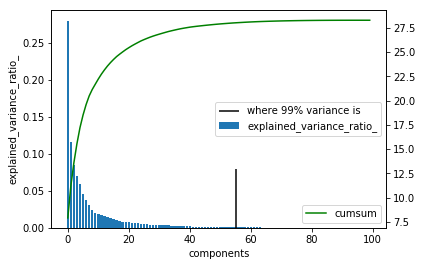

In [131]:
cumsum = np.cumsum(pca.explained_variance_)
fig, ax1 = plt.subplots()
ax1.bar(range(0,100),pca.explained_variance_ratio_,label = 'explained_variance_ratio_')
ax1.set_xlabel('components')
ax1.set_ylabel('explained_variance_ratio_')

ax2 = ax1.twinx()
ax2.plot(range(0,100),cumsum,label='cumsum',color='g')
position = np.where(np.cumsum(pca.explained_variance_ratio_) >= 0.99)[0][0]
ax1.vlines(position,0,0.08,label='where 99% variance is')
ax1.legend(loc = 'right')
ax2.legend(loc = 'lower right')
plt.show()

# redo PCA component is 87

In [132]:
pca = PCA(n_components=55)
train_after_pca_87 = pca.fit_transform(X_scaled_train)
test_after_pca_87 = pca.transform(X_scaled_test)

# model

# XGBRegressor

In [133]:
xgboost = XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [134]:
xgboost.fit(train_after_pca_87,log_train_target)

./xgboost/python-package/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1.7817, missing=None,
       n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
       scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
       verbosity=1)

In [135]:
def alpha_calculation(price_origin_train, X_post_PCA, imputed_data, listype, model):
    #assign values to X,y:
    data_X = imputed_data.drop('SalePrice',axis = 1)
    data_y = imputed_data['SalePrice']
    log_y = np.log(data_y)
    
    #PCA transformation:
    #redo_data_X = scaler.fit(data_X).transform(data_X)
    #trans_redo_data_X = pca.fit_transform(redo_data_X)
    
    #find index 
    index = list(price_origin_train[price_origin_train['SaleCondition'] == listype].index)
    #print(index)
    
    #find the relevant values corresponding to the index
    trans_redo_data_X_dataframe = pd.DataFrame(X_post_PCA).ix[index]
    
    #print(remastered_train,train_X_after_PCA, train_data)
    
    #prediction
    pred = model.predict(trans_redo_data_X_dataframe.values)
    
    #find the alpha corresponding to the abnormal salescondition
    attribute_alpha = log_y.ix[index].values.T/pred
    
    alpha = attribute_alpha.mean()
    origin_mse = mean_squared_error(log_y.ix[index].values.T,pred.reshape(-1,1))
    modified_mse = mean_squared_error(log_y.ix[index].values.T,alpha*pred.reshape(-1,1))
    ratio = (origin_mse-modified_mse)/origin_mse
    return alpha,origin_mse,modified_mse,ratio,model

In [136]:

fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Family',xgboost)

abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Abnorml',xgboost)

adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'AdjLand',xgboost)

all_alpha,all_origin_mse,all_modified_mse,all_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Alloca',xgboost)

par_alpha,par_origin_mse,par_modified_mse,par_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Partial',xgboost)


/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhen

In [137]:
print('fa_alpha: %f origin: %f modified: %f improve %f'%(fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio))

print('abn_alpha: %f origin: %f modified: %f improve %f'%(abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio))

print('adj_alpha: %f origin: %f modified: %f improve %f'%(adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio))

print('all_alpha: %f origin: %f modified: %f improve %f'%(all_alpha,all_origin_mse,all_modified_mse,all_ratio))

print('par_alpha: %f origin: %f modified: %f improve %f'%(par_alpha,par_origin_mse,par_modified_mse,par_ratio))

fa_alpha: 1.001720 origin: 0.010486 modified: 0.010059 improve 0.040752
abn_alpha: 0.999298 origin: 0.009562 modified: 0.009517 improve 0.004679
adj_alpha: 1.004135 origin: 0.004792 modified: 0.002549 improve 0.467939
all_alpha: 0.999938 origin: 0.009329 modified: 0.009335 improve -0.000606
par_alpha: 1.000039 origin: 0.008143 modified: 0.008142 improve 0.000172


In [138]:
sale_condition = test.SaleCondition
alpha_dict = {'Normal':1,'Abnorml':abn_alpha,'AdjLand':adj_alpha,'Alloca':all_alpha,'Family':fa_alpha,'Partial':par_alpha}

In [139]:
pred_without_alpha_xgboost = xgboost.predict(test_after_pca_87)
pred_with_alpha_xgboost = pred_without_alpha_xgboost
for i in range(len(sale_condition)):
    pred_with_alpha_xgboost[i] = alpha_dict[sale_condition[i]]*pred_without_alpha_xgboost[i]
    

In [140]:
pred_with_alpha_xgboost = pd.DataFrame(data = np.exp(pred_with_alpha_xgboost),columns = ['SalePrice'],index = range(1461,2920))
pred_with_alpha_xgboost.index.name = 'Id'
pred_with_alpha_xgboost.to_csv('./pred_with_alpha_xgboost.csv',index = True)


In [141]:
pred_xgboost = xgboost.predict(test_after_pca_87)

In [142]:
pred_xgboost = pd.DataFrame(data = np.exp(pred_xgboost),columns = ['SalePrice'],index = range(1461,2920))
pred_xgboost.index.name = 'Id'
pred_xgboost.to_csv('./pred_xgboost.csv',index = True)

# RandomForestRegressor

In [143]:
rfr = RandomForestRegressor(n_estimators=400)

In [144]:
rfr.fit(train_after_pca_87,log_train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [145]:
pred_rfr = rfr.predict(test_after_pca_87)
pred_rfr = pd.DataFrame(data = np.exp(pred_rfr),columns = ['SalePrice'],index = range(1461,2920))
pred_rfr.index.name = 'Id'
pred_rfr.to_csv('./pred_rfr.csv',index = True)

# GradientBoostingRegressor

In [146]:
# gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
#                                    max_depth=4, max_features='sqrt',
#                                    min_samples_leaf=15, min_samples_split=10, 
#                                    loss='huber', random_state =5)

In [147]:
gbr = GradientBoostingRegressor(
                random_state=1,
                learning_rate=0.015, 
                min_samples_split=2,
                max_features='sqrt',
                n_estimators=3000,
                min_samples_leaf=1,
                subsample=0.2,
                max_depth=3,
            )

In [148]:
gbr.fit(train_after_pca_87,log_train_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.015, loss='ls', max_depth=3,
             max_features='sqrt', max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=3000,
             n_iter_no_change=None, presort='auto', random_state=1,
             subsample=0.2, tol=0.0001, validation_fraction=0.1, verbose=0,
             warm_start=False)

In [149]:
pred_gbr = gbr.predict(test_after_pca_87)
pred_gbr = pd.DataFrame(data = np.exp(pred_gbr),columns = ['SalePrice'],index = range(1461,2920))
pred_gbr.index.name = 'Id'
pred_gbr.to_csv('./pred_gbr.csv',index = True)

# ExtraTreesRegressor

In [150]:
etr = ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=10,
          max_features=0.3, max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)

etr.fit(train_after_pca_87,log_train_target)
pred_etr = etr.predict(test_after_pca_87)
pred_etr = pd.DataFrame(data = np.exp(pred_etr),columns = ['SalePrice'],index = range(1461,2920))
pred_etr.index.name = 'Id'
pred_etr.to_csv('./pred_etr.csv',index = True)

In [151]:
svr = SVR(gamma='scale', C=1.0, epsilon=0.2)
svr.fit(train_after_pca_87,log_train_target)
lasso = Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)
lasso.fit(train_after_pca_87,log_train_target)
kernelridge = KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
            kernel_params=None)
kernelridge.fit(train_after_pca_87,log_train_target)

KernelRidge(alpha=1.0, coef0=1, degree=3, gamma=None, kernel='linear',
      kernel_params=None)

# stacking

In [152]:
from mlxtend.regressor import StackingRegressor

In [153]:
stregr = StackingRegressor(regressors=[xgboost,rfr,gbr,etr],meta_regressor = xgboost)
stregr.fit(train_after_pca_87,log_train_target)

./xgboost/python-package/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
./xgboost/python-package/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


StackingRegressor(meta_regressor=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1.7817, missing=None,
       n_estimators=2200, n_jobs=1, nthread=-1, objective='reg:linear',
       random_state=7, reg_alpha=0.464, reg_lambda=0.8571,
       scale_pos_weight=1, seed=None, silent=1, subsample=0.5213,
       verbosity=1),
         refit=True,
         regressors=[XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.4603, gamma=0.0468,
       importance_type='gain', learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1.7817, missing=None,
       n_estimators=2200, ... n_estimators=5, n_jobs=-1,
          oob_score=False, random_state=0, verbose=0, warm_start=False)],
         store_train_meta_features=False, use_featur

In [154]:
def alpha_calculation(price_origin_train, X_post_PCA, imputed_data, listype, model):
    #assign values to X,y:
    data_X = imputed_data.drop('SalePrice',axis = 1)
    data_y = imputed_data['SalePrice']
    log_y = np.log(data_y)
    
    #PCA transformation:
    #redo_data_X = scaler.fit(data_X).transform(data_X)
    #trans_redo_data_X = pca.fit_transform(redo_data_X)
    
    #find index 
    index = list(price_origin_train[price_origin_train['SaleCondition'] == listype].index)
    #print(index)
    
    #find the relevant values corresponding to the index
    trans_redo_data_X_dataframe = pd.DataFrame(X_post_PCA).ix[index]
    
    #print(remastered_train,train_X_after_PCA, train_data)
    
    #prediction
    pred = model.predict(trans_redo_data_X_dataframe.values)
    
    #find the alpha corresponding to the abnormal salescondition
    attribute_alpha = log_y.ix[index].values.T/pred
    
    alpha = attribute_alpha.mean()
    origin_mse = mean_squared_error(log_y.ix[index].values.T,pred.reshape(-1,1))
    modified_mse = mean_squared_error(log_y.ix[index].values.T,alpha*pred.reshape(-1,1))
    ratio = (origin_mse-modified_mse)/origin_mse
    return alpha,origin_mse,modified_mse,ratio,model

In [155]:

fa_alpha,fa_origin_mse,fa_modified_mse,fa_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Family',stregr)

abn_alpha,abn_origin_mse,abn_modified_mse,abn_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Abnorml',stregr)

adj_alpha,adj_origin_mse,adj_modified_mse,adj_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'AdjLand',stregr)

all_alpha,all_origin_mse,all_modified_mse,all_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Alloca',stregr)

par_alpha,par_origin_mse,par_modified_mse,par_ratio,model = alpha_calculation(train,train_after_pca_87, fullfill_train,'Partial',stregr)


/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:16: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  app.launch_new_instance()
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhengnan/anaconda3/envs/dme/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/Users/hongzhen

In [156]:
pred_without_alpha_stregr = stregr.predict(test_after_pca_87)
pred_with_alpha_stregr = pred_without_alpha_stregr
for i in range(len(sale_condition)):
    pred_with_alpha_stregr[i] = alpha_dict[sale_condition[i]]*pred_without_alpha_stregr[i]

In [157]:
pred_with_alpha_stregr = pd.DataFrame(data = np.exp(pred_with_alpha_stregr),columns = ['SalePrice'],index = range(1461,2920))
pred_with_alpha_stregr.index.name = 'Id'
pred_with_alpha_stregr.to_csv('./pred_with_alpha_stregr.csv',index = True)